In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import PyraLNet as pyral

Investigate stability of the network dynamics in a small 1x1x1 network (-> 2 pyr-, 1 interneuron)

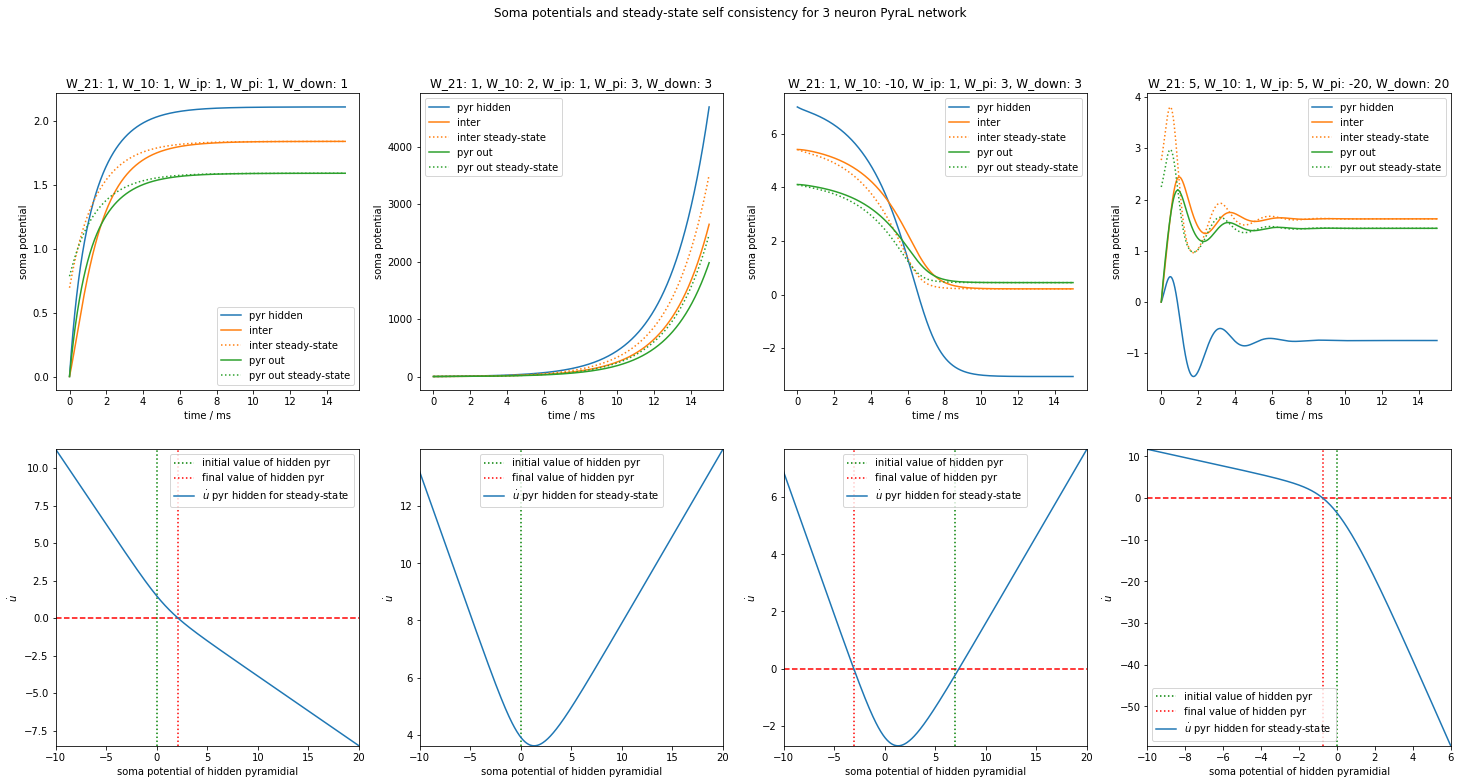

In [20]:
# simulate soma potentials with fixed input rate r_in and teaching potential u_trgt. u_0 is the initial state
# x1 (or u1) = hidden pyramidal soma potential
# x2 (u2) = hidden inter soma potential
# x3 (u3) = output layer pyramidal soma potential
def simulate(r_in, u_trgt, dt, T, u_0=np.zeros(3)):
    N = int(T/dt)
    x1 = np.zeros(N)
    x1.fill(u_0[0])
    x2 = np.zeros(N)
    x2.fill(u_0[1])
    x3 = np.zeros(N)
    x3.fill(u_0[2])
    
    for n in range(0, N-1):
        dx1 = dt*( -(gl+gb+ga)*x1[n] + gb*W_10*r_in + ga*(W_down*act(x3[n]) + W_pi*act(x2[n])) )
        dx2 = dt*( -(gl+gd+gsom)*x2[n] + gd*W_ip*act(x1[n]) + gsom*x3[n] )
        dx3 = dt*( -(gl+gb+gsom)*x3[n] + gb*W_21*act(x1[n]) + gsom*u_trgt )

        x1[n+1] = x1[n] + dx1
        x2[n+1] = x2[n] + dx2
        x3[n+1] = x3[n] + dx3
        
    return np.arange(N)*dt, x1, x2, x3

# in a steady-state of the full network all derivatives of the soma potentials vanish simultaneously
# -> rearange to find steady states of u2 and u3 in terms of u1 and u_trgt
# -> plug into equation for du1/dt = f(u1; r_in, u_trgt) (in then steady-state f(u1)=0)
def f(x, r_in, u_trgt):
    g1 = ga + gb + gl
    g2 = gd + gsom + gl
    g3 = gb + gsom + gl
    
    a = W_down*ga/g1
    b = gb/g3*W_21
    c = ga/g1 *W_pi
    d = gd/g2*W_ip+gsom/g2 *b
    return -x + W_10*r_in/g1 + a*act(b*act(x) + gsom/g3*u_trgt) + c*act(d*act(x) + gsom**2 /(g2*g3)*u_trgt)

# compute steady state of u2 and u3 given u1 and u_target
def steady_state(u1, u_trgt):
    g2 = gd + gsom + gl
    g3 = gb + gsom + gl
    u3 = gb/g3*W_21*act(u1) + gsom/g3*u_trgt
    u2 = gd/g2*W_ip*act(u1) + gsom/g2*u3
    return [u1, u2, u3]

def act(x):
    return pyral.soft_relu(np.array([x]))[0]

N_in = 1
N_hidden = 1
N_out = 1

gsom = 0.8
ga = 0.8
gb = 1
gd = 1
gl = 0.1

W_10 = 1
W_21 = 1
W_ip = 1
W_down = 1
W_pi = 1

r_in = 1
u_trgt = 1

plt.figure(figsize=(25,12))
plt.suptitle("Soma potentials and steady-state self consistency for 3 neuron PyraL network")
for i in range(4):
    
    u_0 = np.zeros(3)
    
    if i==1:
        # now f does not posses a fix point -> network is completely unstable
        W_10 = 2
        W_down = 3
        W_pi = 3
        
    if i==2:
        # for this params there is now a second steady-state. However it's instable.
        # Start close this state and see what happens
        u_0 = steady_state(7, u_trgt)
        W_10 = -10
        
    if i==3:
        # stable network but we see oscillations during settling
        u_0 = np.zeros(3)
        W_10 = 1
        W_21 = 5
        W_ip = 5
        W_down = 20
        W_pi = -20
    
    # how do the soma potentials u1, u2, u3 and steady-state solution for u2, u3 evolve?
    plt.subplot(2,4,1+i)
    T, u1, u2, u3 = simulate(r_in, u_trgt, 0.001, 15, u_0=u_0)
    prox = steady_state(u1, u_trgt)
    plt.plot(T, u1, label="pyr hidden")
    c = plt.plot(T, u2, label="inter")[0].get_color()
    plt.plot(T, prox[1], c=c, label="inter steady-state", ls=":")
    c = plt.plot(T, u3, label="pyr out")[0].get_color()
    plt.plot(T, prox[2], c=c, label="pyr out steady-state", ls=":")
    plt.xlabel("time / ms")
    plt.ylabel("soma potential")
    plt.title("W_21: %d, W_10: %d, W_ip: %d, W_pi: %d, W_down: %d"%(W_21, W_10, W_ip, W_pi, W_down))
    plt.legend()

    # plot f(u1) and mark initial and final values of u1
    plt.subplot(2, 4, 5+i)
    x = np.linspace(-10,20 if i<3 else 6,500)
    y = f(x, r_in, u_trgt)
    plt.plot([np.min(x), np.max(x)], [0,0], c="r", ls="--")
    plt.plot([u1[0], u1[0]], [np.min(y), np.max(y)], c="g", ls=":", label="initial value of hidden pyr")
    plt.plot([u1[-1], u1[-1]], [np.min(y), np.max(y)], c="r", ls=":", label="final value of hidden pyr")
    plt.plot(x,y, label="$\\dot{u}$ pyr hidden for steady-state")
    plt.xlim([np.min(x), np.max(x)])
    plt.ylim([np.min(y), np.max(y)])
    plt.xlabel("soma potential of hidden pyramidial")
    plt.ylabel("$\\dot{u}$")
    plt.legend()
plt.tight_layout()
plt.savefig("stability.png")
plt.show()